In [1]:
%load_ext autoreload
%autoreload 2

# VAE on MNIST images

In [22]:
from train import train_uivi_vae
from plot_utils import plot_mnist_samples, plot_losses
from data_utils import create_mnist_dataloaders
from ui_vae import UIVAE
import matplotlib.pyplot as plt

In [3]:
num_epochs = 20
num_hmc_samples = 5
lr = 1e-3

train_loader, test_loader = create_mnist_dataloaders(img_size = 14, batch_size = 128)
model = UIVAE(dim_x = 14*14, dim_eps = 10, dim_z = 70, latent_dims = [64, 64], T = num_hmc_samples, Ls = num_hmc_samples, step_size = 0.2)

model, losses_mod, losses_ent = train_uivi_vae(model = model, train_loader = train_loader, 
                                               num_epochs = num_epochs,  lr=lr,  
                                               num_hmc_samples=num_hmc_samples)

Epoch 20: 100%|██████████| 469/469 [01:42<00:00,  4.58it/s]


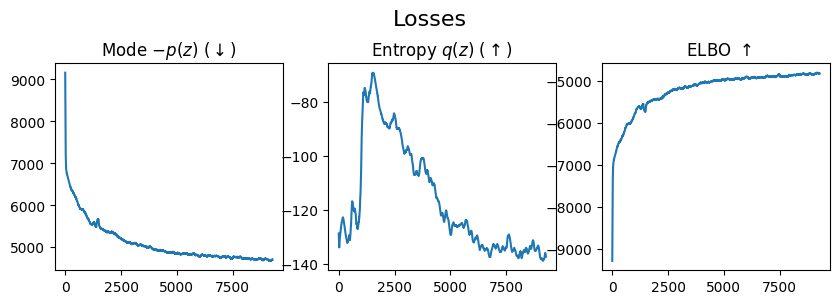

In [4]:
plot_losses(losses_mod, losses_ent)

Original images


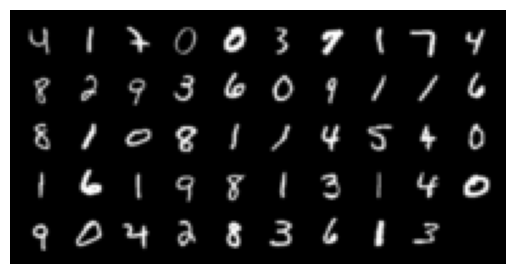

VAE reconstruction:


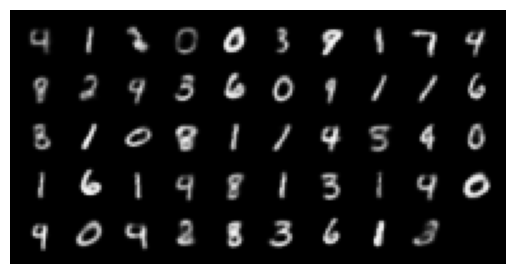

In [23]:
images_recon, fig_orig, fig_recon = plot_mnist_samples(model, test_loader, img_dim = 14)

In [25]:
fig_orig.savefig('original_images.png', bbox_inches = 'tight')
fig_recon.savefig('reconstructed_images.png', bbox_inches = 'tight')